Retrait annuel moyen : 15.60 mètres/an
Médiane annuel : 13.37 mètres/an
Écart-type annuel : 8.67 mètres/an
Année 1890 : 2.67 mètres/an
Année 1925 : 6.22 mètres/an
Année 1935 : 27.56 mètres/an
Année 1942 : 15.19 mètres/an
Année 1948 : 12.93 mètres/an
Année 1992 : 13.76 mètres/an
Année 2004 : 9.33 mètres/an
Année 2010 : 12.97 mètres/an
Année 2016 : 28.88 mètres/an
Année 2022 : 26.53 mètres/an


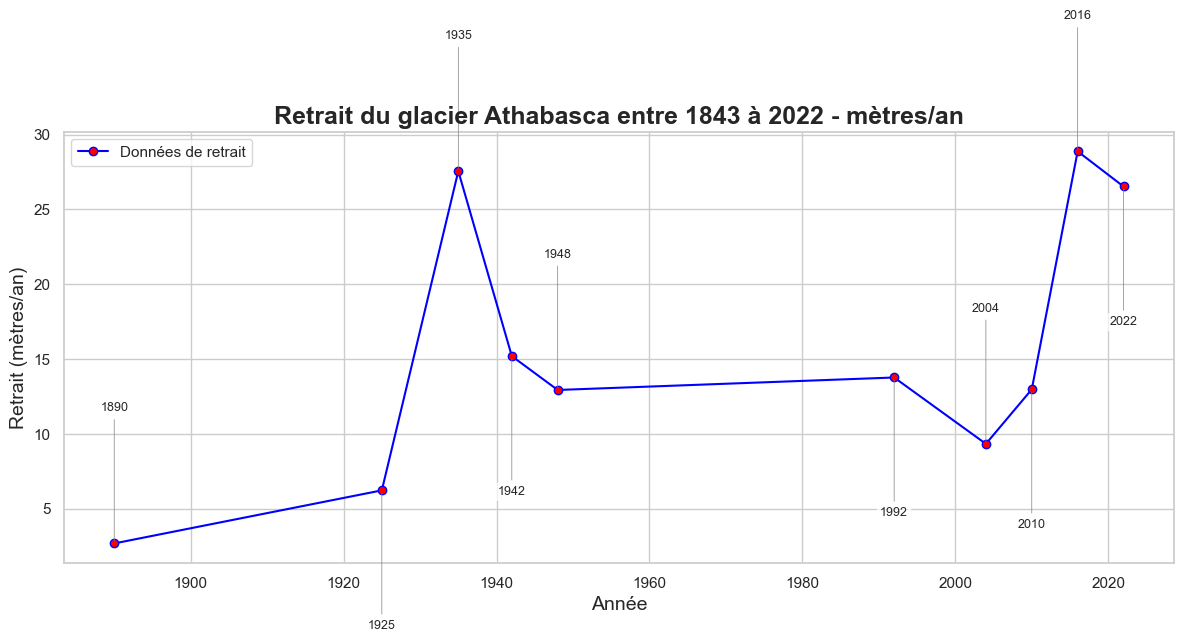

In [45]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gdf = gpd.read_file(r"D:\UQTR\Automne 2024\Ouest\retrait_glacier\retrait_points.shp")
gdf = gdf.to_crs(epsg=32611)
gdf['year'] = pd.to_numeric(gdf['year'], errors='coerce')
gdf = gdf.dropna(subset=['year'])
gdf = gdf[(gdf['year'] >= 1843) & (gdf['year'] <= 2024)]
gdf = gdf.sort_values(by='year').reset_index(drop=True)

years_existing = gdf['year'].values
points_existing = gdf.geometry.values

x_existing = np.array([point.x for point in points_existing])
y_existing = np.array([point.y for point in points_existing])

distances = np.sqrt(np.diff(x_existing)**2 + np.diff(y_existing)**2)
cumulative_distances = np.cumsum(distances)

years_diff = np.diff(years_existing)
retreat_per_year = np.divide(distances, years_diff)

mean_retreat = np.mean(retreat_per_year)
median_retreat = np.median(retreat_per_year)
std_dev_retreat = np.std(retreat_per_year)

print(f"Retrait annuel moyen : {mean_retreat:.2f} mètres/an")
print(f"Médiane annuel : {median_retreat:.2f} mètres/an")
print(f"Écart-type annuel : {std_dev_retreat:.2f} mètres/an")

for year, retreat in zip(years_existing[1:], retreat_per_year):
    print(f"Année {year} : {retreat:.2f} mètres/an")

plt.figure(figsize=(12, 7))
plt.plot(years_existing[1:], retreat_per_year, marker='o', linestyle='-', color='blue', markerfacecolor='red', label='Données de retrait')

# Adjust the label positions and add leader lines
for i, (x, y) in enumerate(zip(years_existing[1:], retreat_per_year)):
    xytext = (x, y + std_dev_retreat) if i % 2 == 0 else (x, y - std_dev_retreat)
    va = 'bottom' if i % 2 == 0 else 'top'
    plt.annotate(
        f'{int(x)}',
        xy=(x, y),
        xytext=xytext,
        textcoords='data',
        fontsize=9,
        ha='center',
        va=va,
        arrowprops=dict(arrowstyle='-', color='gray', linewidth=0.5),
        bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
    )

plt.legend()
plt.title('Retrait du glacier Athabasca entre 1843 à 2022 - mètres/an', fontsize=18, fontweight='bold')
plt.xlabel('Année', fontsize=14)
plt.ylabel('Retrait (mètres/an)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


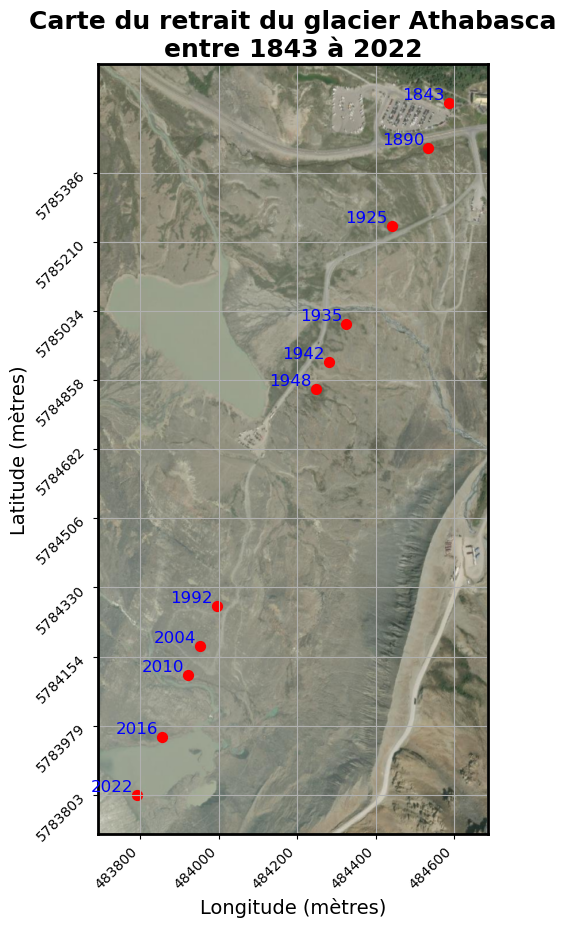

In [32]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx  

fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Points de retrait')

for x, y, label in zip(x_existing, y_existing, years_existing):
    ax.text(x - 10, y + 10, str(label), fontsize=12, ha='right', color='blue')

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=gdf.crs.to_string(), attribution='')

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 100, maxx + 100)
ax.set_ylim(miny - 100, maxy + 100)

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.title('Carte du retrait du glacier Athabasca\nentre 1843 à 2022', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Longitude (mètres)', fontsize=14)
plt.ylabel('Latitude (mètres)', fontsize=14)
plt.grid(True)

ax.set_yticks(np.arange(miny, maxy, step=(maxy - miny) / 10))
ax.set_yticklabels(np.arange(miny, maxy, step=(maxy - miny) / 10).astype(int), rotation=45, ha='right', fontsize=10)

plt.savefig('carte_retrait_glacier.png', dpi=300)
plt.show()


c:\Users\thier\miniforge3\envs\geospatial_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:           retreat_rate   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.114
Method:                 Least Squares   F-statistic:                   0.08094
Date:                Tue, 08 Oct 2024   Prob (F-statistic):              0.783
Time:                        20:58:33   Log-Likelihood:                -35.733
No. Observations:                  10   AIC:                             75.47
Df Residuals:                       8   BIC:                             76.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.1563      5.928      2.388      0.0

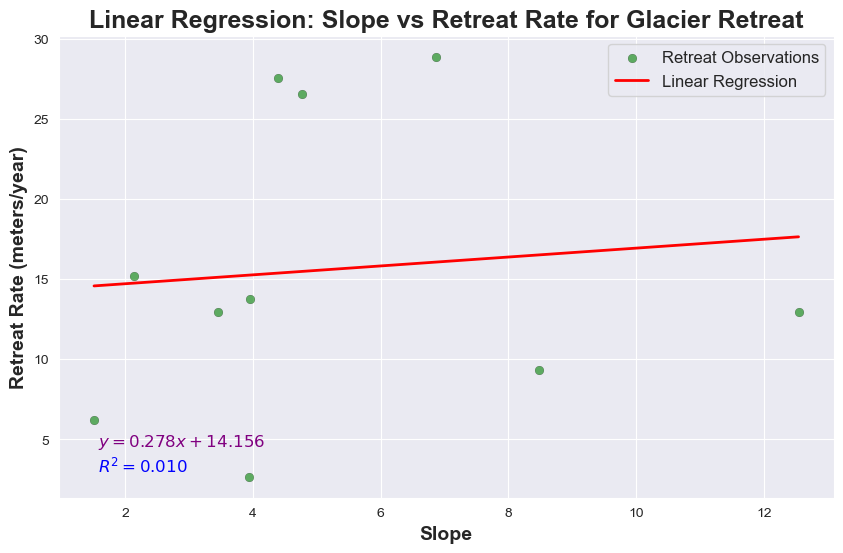

In [12]:
import geopandas as gpd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load shapefile
gdf = gpd.read_file(r"D:\UQTR\Automne 2024\Ouest\retrait_glacier\retrait_points.shp")
gdf = gdf.to_crs(epsg=32611)

# Filter and sort the data
gdf['year'] = pd.to_numeric(gdf['year'], errors='coerce')
gdf = gdf.dropna(subset=['year'])
gdf = gdf[(gdf['year'] >= 1843) & (gdf['year'] <= 2024)]
gdf = gdf.sort_values(by='year').reset_index(drop=True)

# Extract existing points and years
years_existing = gdf['year'].values
points_existing = gdf.geometry.values

x_existing = np.array([point.x for point in points_existing])
y_existing = np.array([point.y for point in points_existing])

# Calculate distances and retreat per year
distances = np.sqrt(np.diff(x_existing)**2 + np.diff(y_existing)**2)
years_diff = np.diff(years_existing)
retreat_per_year = np.divide(distances, years_diff)

# Adding retreat_per_year to the GeoDataFrame (skip the first row since no retreat for the first point)
gdf = gdf.iloc[1:].copy()
gdf['retreat_rate'] = retreat_per_year

# Perform linear regression (slope ~ retreat_rate)
model = ols('retreat_rate ~ slope', data=gdf).fit()
print(model.summary())

# Generate values for the regression line
x = np.linspace(gdf['slope'].min(), gdf['slope'].max(), 500)
x_df = gpd.GeoDataFrame({'slope': x})
y_pred = model.predict(exog=x_df)

# Set the style of the graph
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Scatter plot for the slope and retreat rate
sns.scatterplot(x='slope', y='retreat_rate', data=gdf, alpha=0.6, color='g', s=40, label='Retreat Observations', edgecolor='black', linewidth=0.2)

# Plot the regression line
plt.plot(x, y_pred, color='r', linestyle='-', linewidth=2, label='Linear Regression')

# Add statistical information
r_squared = model.rsquared
intercept = model.params['Intercept']
slope = model.params['slope']
plt.text(0.05, 0.05, f'$R^2 = {r_squared:.3f}$', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color='blue', verticalalignment='bottom')
plt.text(0.05, 0.10, f'$y = {slope:.3f}x + {intercept:.3f}$', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color='purple', verticalalignment='bottom')

# Graph settings
plt.xlabel('Slope', fontsize=14, fontweight='bold')
plt.ylabel('Retreat Rate (meters/year)', fontsize=14, fontweight='bold')
plt.title('Linear Regression: Slope vs Retreat Rate for Glacier Retreat', fontsize=18, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)

plt.show()


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le fichier CSV téléchargé
new_file_path = r'D:\Downloads\T025R10W5-ATA-1901-01-01_2024-08-31-PID114547315.csv'
new_data = pd.read_csv(new_file_path, encoding='latin1')

# Convertir la colonne 'Date' en format datetime
new_data['Date'] = pd.to_datetime(new_data['Date'], format='%Y')

# Définir le style pour seaborn
sns.set(style='whitegrid')

# Tracer la température moyenne au fil du temps en utilisant seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=new_data, x='Date', y='Air Temp. Avg. (°C)', color='darkgreen', linewidth=2.5)

# Améliorer l'apparence du graphique
plt.xlabel('Année', fontsize=16, fontweight='bold', labelpad=15)
plt.ylabel('Température moyenne (°C)', fontsize=16, fontweight='bold', labelpad=15)
plt.title('Température moyenne de l'air au fil du temps', fontsize=20, fontweight='bold', pad=20)
plt.grid(True, linestyle='--', alpha=0.5)

# Ajouter des personnalisations pour un rendu soigné
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=13)
plt.tight_layout()

# Ajouter des annotations pour les points de début et de fin pour plus de contexte
plt.annotate(f"{new_data['Air Temp. Avg. (°C)'].iloc[0]:.2f}°C", 
             (new_data['Date'].iloc[0], new_data['Air Temp. Avg. (°C)'].iloc[0]), 
             textcoords="offset points", xytext=(-10,10), ha='center', fontsize=12, color='darkgreen', fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', edgecolor='darkgreen', facecolor='white'))

plt.annotate(f"{new_data['Air Temp. Avg. (°C)'].iloc[-1]:.2f}°C", 
             (new_data['Date'].iloc[-1], new_data['Air Temp. Avg. (°C)'].iloc[-1]), 
             textcoords="offset points", xytext=(-10,-15), ha='center', fontsize=12, color='darkgreen', fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', edgecolor='darkgreen', facecolor='white'))

# Ajouter une légende pour plus d'informations
plt.legend(['Température moyenne'], loc='upper left', fontsize=13, frameon=True, fancybox=True, framealpha=1, shadow=True, borderpad=1)

# Afficher le graphique
plt.show()

SyntaxError: unterminated string literal (detected at line 22) (2542489859.py, line 22)

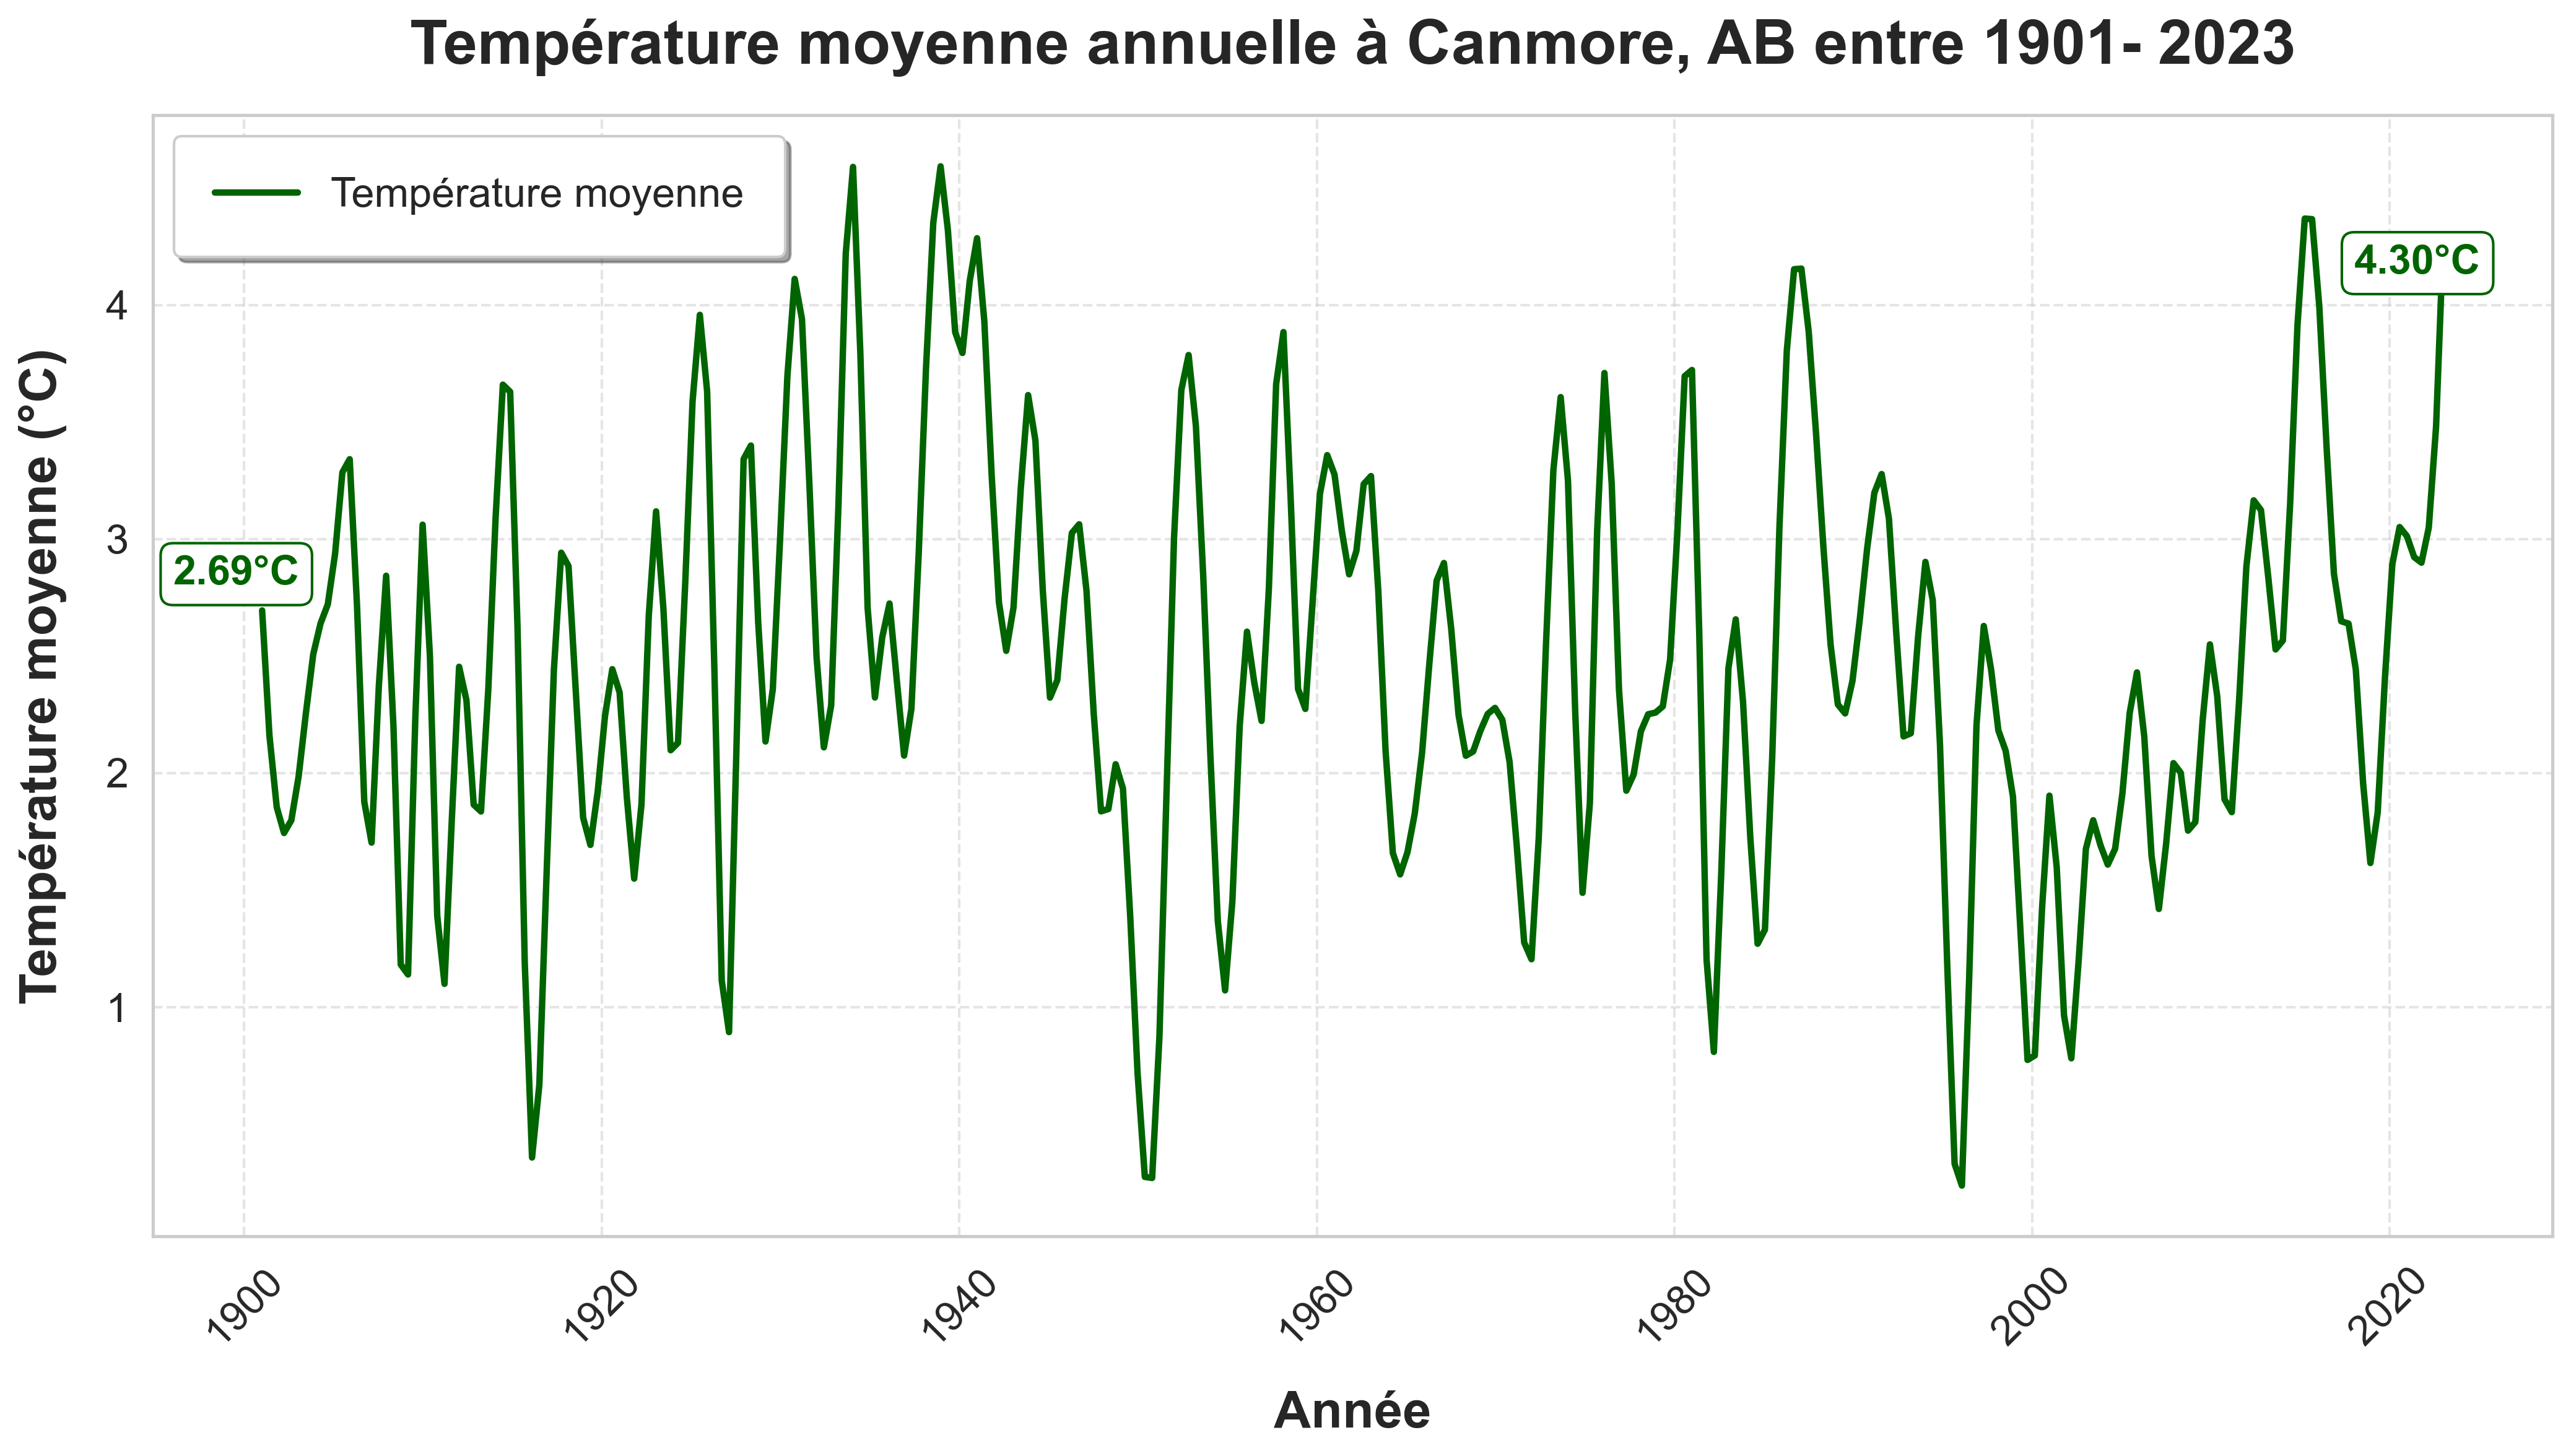

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Charger le fichier CSV téléchargé
new_file_path = r'D:\Downloads\T025R10W5-ATA-1901-01-01_2024-08-31-PID114547315.csv'
new_data = pd.read_csv(new_file_path, encoding='latin1')

# Convertir la colonne 'Date' en format datetime
new_data['Date'] = pd.to_datetime(new_data['Date'], format='%Y')

# Convertir la colonne 'Date' en format numérique pour l'interpolation
new_data['Year'] = new_data['Date'].dt.year

# Définir le style pour seaborn
sns.set(style='whitegrid')

# Créer une interpolation pour lisser la courbe
x = new_data['Year']
y = new_data['Air Temp. Avg. (°C)']

# Générer des points supplémentaires pour lisser la courbe
x_smooth = np.linspace(x.min(), x.max(), 300)
spline = make_interp_spline(x, y, k=3)
y_smooth = spline(x_smooth)

# Tracer la température moyenne au fil du temps en utilisant seaborn
plt.figure(figsize=(14, 8), dpi=300)
plt.plot(x_smooth, y_smooth, color='darkgreen', linewidth=2.5)

# Améliorer l'apparence du graphique
plt.xlabel('Année', fontsize=20, fontweight='bold', labelpad=15)
plt.ylabel('Température moyenne (°C)', fontsize=20, fontweight='bold', labelpad=15)
plt.title('Température moyenne annuelle à Canmore, AB entre 1901- 2023', fontsize=24, fontweight='bold', pad=20)
plt.grid(True, linestyle='--', alpha=0.5)

# Ajouter des personnalisations pour un rendu soigné
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.tight_layout()

# Ajouter des annotations pour les points de début et de fin pour plus de contexte
plt.annotate(f"{y.iloc[0]:.2f}°C", 
             (x.iloc[0], y.iloc[0]), 
             textcoords="offset points", xytext=(-10,10), ha='center', fontsize=16, color='darkgreen', fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', edgecolor='darkgreen', facecolor='white'))

plt.annotate(f"{y.iloc[-1]:.2f}°C", 
             (x.iloc[-1], y.iloc[-1]), 
             textcoords="offset points", xytext=(-10,-15), ha='center', fontsize=16, color='darkgreen', fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', edgecolor='darkgreen', facecolor='white'))

# Ajouter une légende pour plus d'informations
plt.legend(['Température moyenne'], loc='upper left', fontsize=16, frameon=True, fancybox=True, framealpha=1, shadow=True, borderpad=1)

# Afficher le graphique
plt.show()
